# TASK 2 - TIER A: The Statistician

## Goal
Build a **Random Forest/XGBoost classifier** using only numerical linguistic features from Task 1.

---

## The Approach

### What We're Building
- **Input:** Numerical features (sentence variance, punctuation, readability, etc.)
- **Output:** 3-class prediction (Human, AI Vanilla, AI Styled)
- **Method:** Traditional ML (Random Forest first, then XGBoost)

### The Challenge
**Dataset (Twain + Austen):**
- Class 1 (Human): 470 paragraphs
- Class 2 (AI Vanilla): 464 paragraphs  
- Class 3 (AI Styled): 494 paragraphs
- **Total:** 1428 paragraphs (relatively balanced!)

**Key Insights from Task 1:**
1. **Sentence variance is THE STRONGEST signal** (22σ effect!)
2. Length bias: Human 134 words, AI 90-97 words (37-44 word gap)
3. Punctuation: Human uses 3x-31x more dramatic punctuation

**Expected Challenges:**
1. Length bias may help OR hurt (confounds TTR/Hapax)
2. AI Vanilla vs AI Styled may be hard to distinguish (both AI)
3. Will the 22σ sentence variance translate to high accuracy?

---

## Feature Set (10 Features)

Based on Task 1 analysis:

### ✅ Strong Discriminative Features
1. **Sentence Length Mean** (avg words per sentence)
2. **Sentence Length Variance** ⭐ (Human 3x more, strongest signal)
3. **Paragraph Length** (total words - controls for length bias)
4. **TTR** (Type-Token Ratio - vocabulary diversity)
5. **Flesch-Kincaid Grade Mean** (readability)
6. **Flesch-Kincaid Grade Variance** (Human 2x more)
7. **Semicolons per 1000 words** (Human 3x more)
8. **Em-dashes per 1000 words** (Human 1.6x more)
9. **Exclamations per 1000 words** (Human >> AI)
10. **Commas per 1000 words**

### ❌ Excluded Features
- **Hapax Ratio** (redundant with TTR, same length bias)
- **Adj/Noun Ratio** (p=0.812, no signal)

---

## Prediction

**If Features Work:**
- Expected accuracy: 70-85% (3-way classification)
- Human should be easily distinguished (sentence variance)
- AI Vanilla vs AI Styled may overlap

**If Features Struggle:**
- Accuracy: 40-60% (barely better than random 33%)
- Root cause: Era differences mask human/AI signal OR AI styled successfully mimics Victorian patterns

**Either outcome is valid research!** We document WHY.

---

## Step 1: Import Libraries

In [1]:
# Core libraries
import json
import pandas as pd
import numpy as np
from pathlib import Path
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from textstat import flesch_kincaid_grade

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    precision_recall_fscore_support
)

# XGBoost (optional - we'll use Random Forest as primary model)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost not installed (optional - we'll focus on Random Forest)")
    print("   To install: pip install xgboost")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All required libraries imported successfully!")
print("✅ Random Forest will be our primary model")

✅ XGBoost available
✅ All required libraries imported successfully!
✅ Random Forest will be our primary model
✅ All required libraries imported successfully!
✅ Random Forest will be our primary model


---

## Step 2: Download NLTK Data (if needed)

In [2]:
# Download required NLTK data
import nltk

print("Downloading NLTK data (this may take a moment)...\n")

# Download punkt tokenizer
try:
    nltk.data.find('tokenizers/punkt')
    print("✅ NLTK punkt already downloaded")
except LookupError:
    print("📥 Downloading NLTK punkt tokenizer...")
    nltk.download('punkt', quiet=False)
    print("✅ punkt downloaded!")

# Download punkt_tab (newer version needed by some NLTK versions)
try:
    nltk.data.find('tokenizers/punkt_tab')
    print("✅ NLTK punkt_tab already downloaded")
except LookupError:
    print("📥 Downloading NLTK punkt_tab...")
    nltk.download('punkt_tab', quiet=False)
    print("✅ punkt_tab downloaded!")

# Download POS tagger
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
    print("✅ NLTK POS tagger already downloaded")
except LookupError:
    print("📥 Downloading NLTK POS tagger...")
    nltk.download('averaged_perceptron_tagger', quiet=False)
    print("✅ POS tagger downloaded!")

# Download averaged_perceptron_tagger_eng (newer version)
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
    print("✅ NLTK POS tagger (eng) already downloaded")
except LookupError:
    print("📥 Downloading NLTK POS tagger (eng)...")
    nltk.download('averaged_perceptron_tagger_eng', quiet=False)
    print("✅ POS tagger (eng) downloaded!")

print("\n✅ All NLTK data ready!")


✅ NLTK punkt already downloaded
✅ NLTK punkt_tab already downloaded
✅ NLTK POS tagger already downloaded
✅ NLTK POS tagger (eng) already downloaded

✅ All NLTK data ready!


---

## Step 3: Load Dataset

Load all three classes from Task 0.

In [3]:
# Define paths (updated for Twain + Austen dataset)
DATA_DIR = Path('../TASK0/data/dataset/twain_austen')
CLASS1_FILE = DATA_DIR / 'class1_human.jsonl'
CLASS2_FILE = DATA_DIR / 'class2.txt'
CLASS3_FILE = DATA_DIR / 'class3.txt'

print("Loading datasets...\n")

# Load Class 1 (Human - JSONL format)
class1_texts = []
if CLASS1_FILE.exists():    
    with open(CLASS1_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():  # Skip empty lines
                data = json.loads(line.strip())
                class1_texts.append(data['text'])
    print(f"✅ Class 1 (Human): {len(class1_texts)} paragraphs loaded")
else:
    print(f"❌ Class 1 file not found: {CLASS1_FILE}")

# Load Class 2 (AI Vanilla - TXT format, one paragraph per line)
class2_texts = []
if CLASS2_FILE.exists():
    with open(CLASS2_FILE, 'r', encoding='utf-8') as f:
        class2_texts = [line.strip() for line in f if line.strip()]
    print(f"✅ Class 2 (AI Vanilla): {len(class2_texts)} paragraphs loaded")
else:
    print(f"❌ Class 2 file not found: {CLASS2_FILE}")

# Load Class 3 (AI Styled - TXT format, one paragraph per line)
class3_texts = []
if CLASS3_FILE.exists():
    with open(CLASS3_FILE, 'r', encoding='utf-8') as f:
        class3_texts = [line.strip() for line in f if line.strip()]
    print(f"✅ Class 3 (AI Styled): {len(class3_texts)} paragraphs loaded")
else:
    print(f"❌ Class 3 file not found: {CLASS3_FILE}")

# Create combined dataset
all_texts = class1_texts + class2_texts + class3_texts
all_labels = (
    ['Human'] * len(class1_texts) + 
    ['AI_Vanilla'] * len(class2_texts) + 
    ['AI_Styled'] * len(class3_texts)
)

print(f"\n📊 Total dataset: {len(all_texts)} paragraphs")

if len(all_texts) > 0:
    print(f"   - Human: {len(class1_texts)} ({len(class1_texts)/len(all_texts)*100:.1f}%)")
    print(f"   - AI Vanilla: {len(class2_texts)} ({len(class2_texts)/len(all_texts)*100:.1f}%)")
    print(f"   - AI Styled: {len(class3_texts)} ({len(class3_texts)/len(all_texts)*100:.1f}%)")
else:
    print("❌ ERROR: No data loaded!")
    print("   Please run task0_data_creation.ipynb first to generate the dataset.")


Loading datasets...

✅ Class 1 (Human): 470 paragraphs loaded
✅ Class 2 (AI Vanilla): 464 paragraphs loaded
✅ Class 3 (AI Styled): 494 paragraphs loaded

📊 Total dataset: 1428 paragraphs
   - Human: 470 (32.9%)
   - AI Vanilla: 464 (32.5%)
   - AI Styled: 494 (34.6%)


---

## Step 4: Feature Engineering

Extract all 10 numerical features from each paragraph.

In [4]:
def extract_features(text):
    """
    Extract 10 linguistic features from a text paragraph.
    
    Returns dict with features:
    1. sent_length_mean
    2. sent_length_variance
    3. para_length (total words)
    4. ttr (Type-Token Ratio)
    5. fk_grade_mean
    6. fk_grade_variance
    7. semicolons_per_1k
    8. emdashes_per_1k
    9. exclamations_per_1k
    10. commas_per_1k
    """
    
    # Tokenize sentences
    sentences = sent_tokenize(text)
    
    # Tokenize words (alphanumeric only, lowercase)
    words = word_tokenize(text.lower())
    words = [w for w in words if w.isalnum()]
    
    # 1-2: Sentence length statistics
    sent_lengths = [len(word_tokenize(s)) for s in sentences]
    sent_length_mean = np.mean(sent_lengths) if sent_lengths else 0
    sent_length_variance = np.var(sent_lengths) if len(sent_lengths) > 1 else 0
    
    # 3: Paragraph length
    para_length = len(words)
    
    # 4: Type-Token Ratio (TTR)
    unique_words = set(words)
    ttr = len(unique_words) / len(words) if words else 0
    
    # 5-6: Flesch-Kincaid Grade statistics
    fk_grades = []
    for sent in sentences:
        if len(sent.split()) > 3:  # Need at least 3 words for FK
            try:
                grade = flesch_kincaid_grade(sent)
                fk_grades.append(grade)
            except:
                pass
    
    fk_grade_mean = np.mean(fk_grades) if fk_grades else 0
    fk_grade_variance = np.var(fk_grades) if len(fk_grades) > 1 else 0
    
    # 7-10: Punctuation density (per 1000 words)
    # Normalize by word count to handle length differences
    word_count_normalized = max(para_length / 1000, 0.001)  # Avoid division by zero
    
    semicolons = text.count(';')
    emdashes = text.count('—') + text.count('--')  # Count both em-dash variants
    exclamations = text.count('!')
    commas = text.count(',')
    
    semicolons_per_1k = semicolons / word_count_normalized
    emdashes_per_1k = emdashes / word_count_normalized
    exclamations_per_1k = exclamations / word_count_normalized
    commas_per_1k = commas / word_count_normalized
    
    return {
        'sent_length_mean': sent_length_mean,
        'sent_length_variance': sent_length_variance,
        'para_length': para_length,
        'ttr': ttr,
        'fk_grade_mean': fk_grade_mean,
        'fk_grade_variance': fk_grade_variance,
        'semicolons_per_1k': semicolons_per_1k,
        'emdashes_per_1k': emdashes_per_1k,
        'exclamations_per_1k': exclamations_per_1k,
        'commas_per_1k': commas_per_1k
    }

print("✅ Feature extraction function defined")
print("\nTesting on sample text...")

# Test on first paragraph
if all_texts:
    sample_features = extract_features(all_texts[0])
    print("\nSample features:")
    for feature, value in sample_features.items():
        print(f"  {feature}: {value:.3f}")

✅ Feature extraction function defined

Testing on sample text...

Sample features:
  sent_length_mean: 33.333
  sent_length_variance: 139.556
  para_length: 84.000
  ttr: 0.667
  fk_grade_mean: 9.958
  fk_grade_variance: 7.551
  semicolons_per_1k: 23.810
  emdashes_per_1k: 11.905
  exclamations_per_1k: 0.000
  commas_per_1k: 71.429

Sample features:
  sent_length_mean: 33.333
  sent_length_variance: 139.556
  para_length: 84.000
  ttr: 0.667
  fk_grade_mean: 9.958
  fk_grade_variance: 7.551
  semicolons_per_1k: 23.810
  emdashes_per_1k: 11.905
  exclamations_per_1k: 0.000
  commas_per_1k: 71.429


### Extract Features for All Paragraphs

This may take 1-2 minutes for 1000 paragraphs...

In [5]:
print("Extracting features for all paragraphs...")
print("This may take 1-2 minutes...\n")

# Extract features for all texts
features_list = []
for i, text in enumerate(all_texts):
    if (i + 1) % 100 == 0:
        print(f"  Processed {i + 1}/{len(all_texts)} paragraphs...")
    
    features = extract_features(text)
    features['label'] = all_labels[i]
    features['text_preview'] = text[:100] + '...'  # For debugging
    features_list.append(features)

# Create DataFrame
df = pd.DataFrame(features_list)

print(f"\n✅ Feature extraction complete!")
print(f"   Dataset shape: {df.shape}")
print(f"   Features: {len(df.columns) - 2} numerical + 1 label + 1 text preview")

# Display first few rows
print("\n📊 First 5 rows:")
df.head()

Extracting features for all paragraphs...
This may take 1-2 minutes...

  Processed 100/1428 paragraphs...
  Processed 200/1428 paragraphs...
  Processed 300/1428 paragraphs...
  Processed 400/1428 paragraphs...
  Processed 500/1428 paragraphs...
  Processed 600/1428 paragraphs...
  Processed 700/1428 paragraphs...
  Processed 800/1428 paragraphs...
  Processed 900/1428 paragraphs...
  Processed 1000/1428 paragraphs...
  Processed 1100/1428 paragraphs...
  Processed 1200/1428 paragraphs...
  Processed 1300/1428 paragraphs...
  Processed 1400/1428 paragraphs...
  Processed 200/1428 paragraphs...
  Processed 300/1428 paragraphs...
  Processed 400/1428 paragraphs...
  Processed 500/1428 paragraphs...
  Processed 600/1428 paragraphs...
  Processed 700/1428 paragraphs...
  Processed 800/1428 paragraphs...
  Processed 900/1428 paragraphs...
  Processed 1000/1428 paragraphs...
  Processed 1100/1428 paragraphs...
  Processed 1200/1428 paragraphs...
  Processed 1300/1428 paragraphs...
  Process

,sent_length_mean,sent_length_variance,para_length,ttr,fk_grade_mean,fk_grade_variance,semicolons_per_1k,emdashes_per_1k,exclamations_per_1k,commas_per_1k,label,text_preview
0,33.333333,139.555556,84,0.666667,9.957752,7.550767,23.809524,11.904762,0.00000,71.428571,Human,The old lady pulled her spectacles down and lo...
1,33.666667,219.555556,81,0.691358,10.294079,38.732388,0.000000,12.345679,0.00000,74.074074,Human,"Tom did play hookey, and he had a very good ti..."
2,36.333333,196.888889,192,0.593750,13.877675,22.098980,0.000000,15.625000,0.00000,72.916667,Human,"Within two minutes, or even less, he had forgo..."
3,13.133333,77.315556,164,0.652439,5.587378,14.528648,6.097561,24.390244,0.00000,48.780488,Human,The summer evenings were long. It was not dark...
4,23.400000,305.040000,99,0.696970,6.421946,44.934334,10.101010,0.000000,10.10101,60.606061,Human,The new boy took two broad coppers out of his ...


---

## Step 5: Exploratory Data Analysis (EDA)

Visualize feature distributions across classes.

In [6]:
# Basic statistics by class
print("📊 FEATURE STATISTICS BY CLASS\n")
print("=" * 80)

feature_cols = [
    'sent_length_mean', 'sent_length_variance', 'para_length', 'ttr',
    'fk_grade_mean', 'fk_grade_variance', 'semicolons_per_1k', 
    'emdashes_per_1k', 'exclamations_per_1k', 'commas_per_1k'
]

for feature in feature_cols:
    print(f"\n{feature.upper().replace('_', ' ')}:")
    print("-" * 80)
    stats = df.groupby('label')[feature].agg(['mean', 'std', 'min', 'max'])
    print(stats.round(3))

📊 FEATURE STATISTICS BY CLASS


SENT LENGTH MEAN:
--------------------------------------------------------------------------------
              mean     std    min    max
label                                   
AI_Styled   20.880   5.522  9.286   43.0
AI_Vanilla  18.794   3.972  9.833   31.0
Human       33.502  20.399  7.188  203.0

SENT LENGTH VARIANCE:
--------------------------------------------------------------------------------
               mean      std   min       max
label                                       
AI_Styled    50.146   39.505  0.00   270.800
AI_Vanilla   40.775   28.077  0.56   183.440
Human       400.043  616.393  0.00  6576.889

PARA LENGTH:
--------------------------------------------------------------------------------
               mean     std  min  max
label                                
AI_Styled    88.800  18.905   44  155
AI_Vanilla   93.614  19.150   44  152
Human       128.921  43.031   75  250

TTR:
--------------------------------------------

### Visualize Key Features

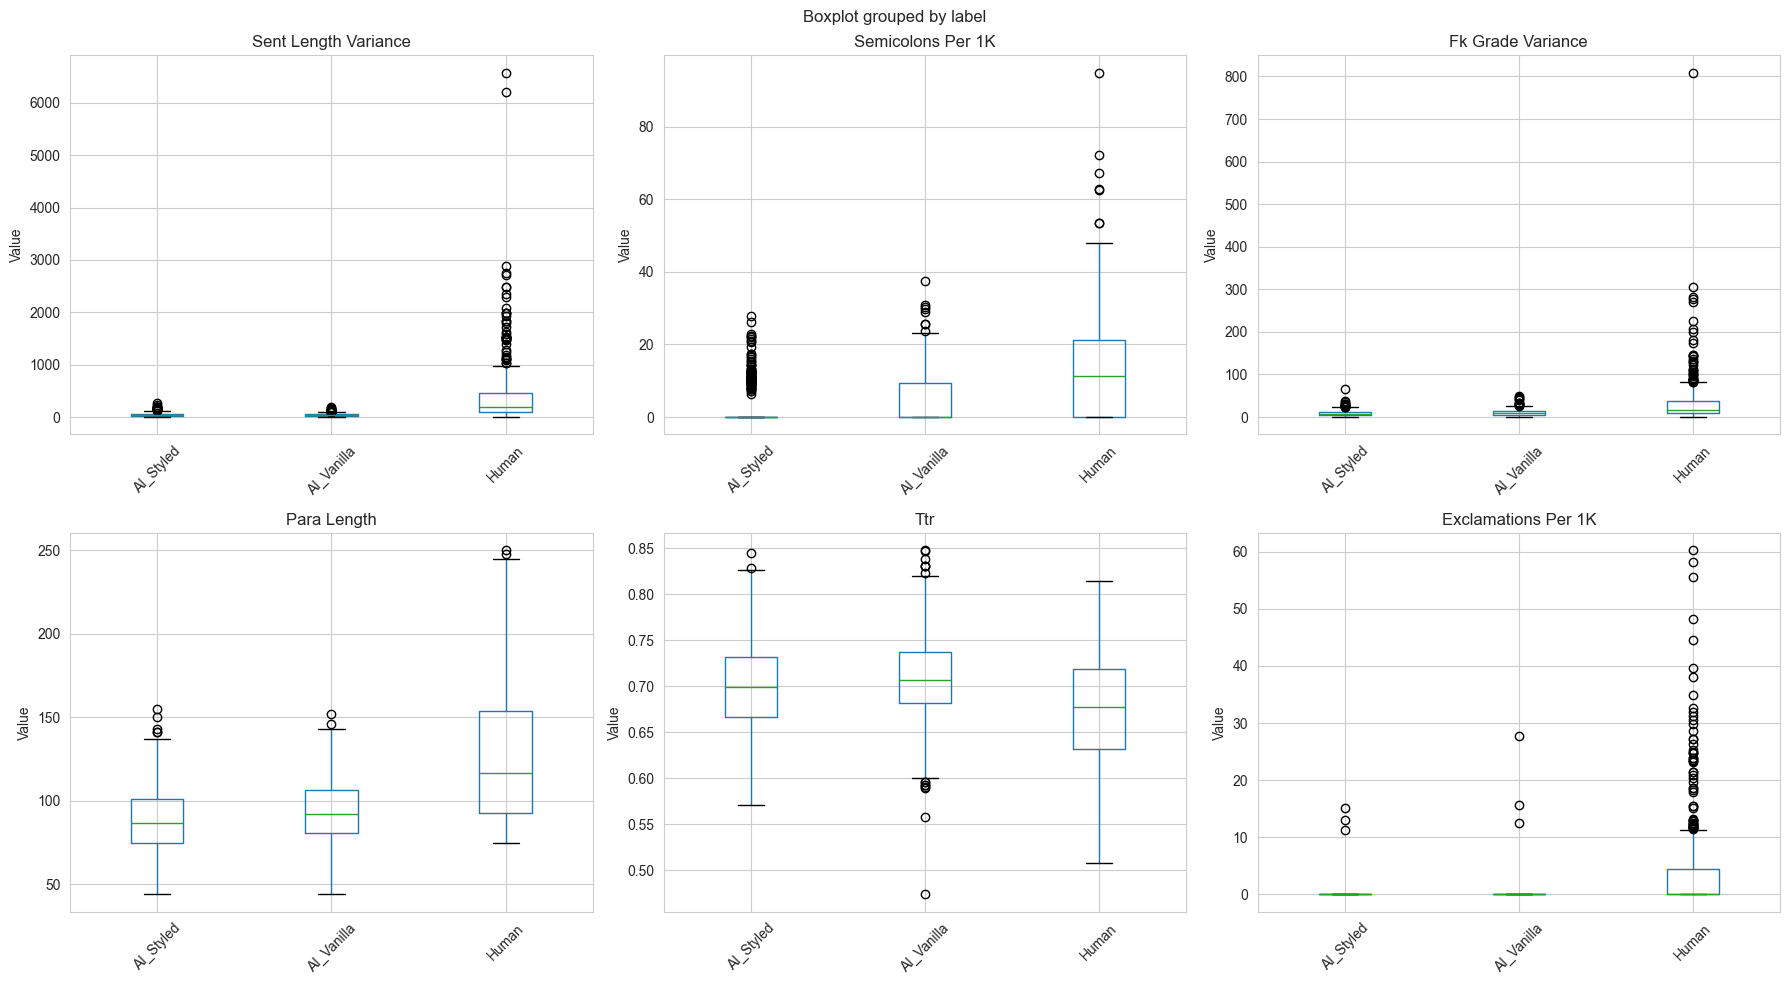

✅ Visualizations complete


In [7]:
# Box plots for top 6 features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Key Features by Class', fontsize=16, fontweight='bold')

top_features = [
    'sent_length_variance',
    'semicolons_per_1k',
    'fk_grade_variance',
    'para_length',
    'ttr',
    'exclamations_per_1k'
]

for idx, feature in enumerate(top_features):
    ax = axes[idx // 3, idx % 3]
    
    # Box plot
    df.boxplot(column=feature, by='label', ax=ax)
    ax.set_title(feature.replace('_', ' ').title())
    ax.set_xlabel('')
    ax.set_ylabel('Value')
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("✅ Visualizations complete")

### Feature Correlation Heatmap

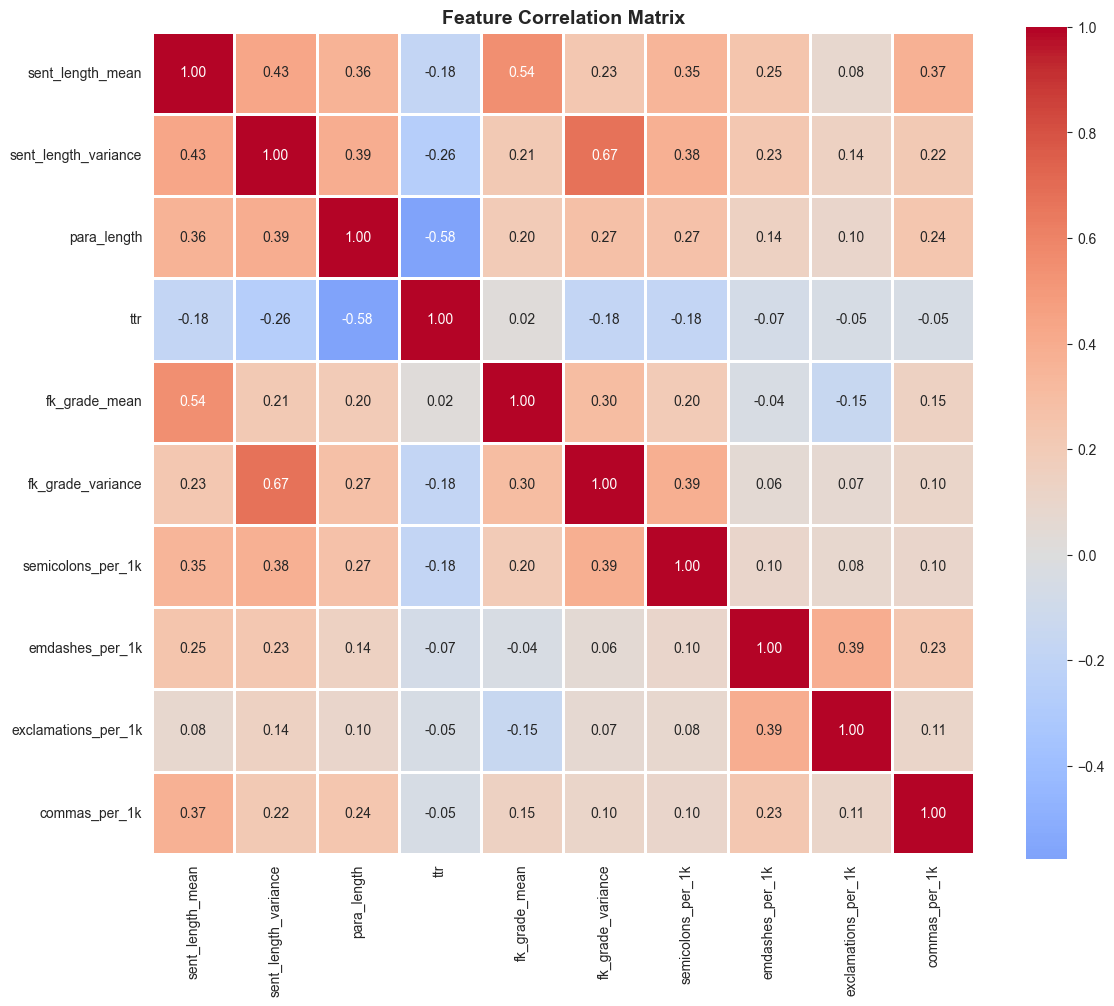


🔍 Key Observations:
   - High correlations (>0.7) indicate redundant features
   - Look for TTR vs para_length correlation (length bias)


In [8]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df[feature_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Key Observations:")
print("   - High correlations (>0.7) indicate redundant features")
print("   - Look for TTR vs para_length correlation (length bias)")

---

## Step 6: Prepare Data for ML

Split into train/test sets with stratification.

In [9]:
# Prepare features and labels
X = df[feature_cols].values
y = df['label'].values

# Encode labels (Human=0, AI_Vanilla=1, AI_Styled=2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {i}")

# Train/test split (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded  # Maintain class proportions
)

print(f"\n📊 Data Split:")
print(f"   Training set: {len(X_train)} samples")
print(f"   Test set: {len(X_test)} samples")

# Show class distribution in train/test
print(f"\n   Train class distribution:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y_train == i)
    print(f"      {label}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\n   Test class distribution:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y_test == i)
    print(f"      {label}: {count} ({count/len(y_test)*100:.1f}%)")

# Feature scaling (standardize to mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Feature scaling complete (mean=0, std=1)")

Label encoding:
  AI_Styled: 0
  AI_Vanilla: 1
  Human: 2

📊 Data Split:
   Training set: 1142 samples
   Test set: 286 samples

   Train class distribution:
      AI_Styled: 395 (34.6%)
      AI_Vanilla: 371 (32.5%)
      Human: 376 (32.9%)

   Test class distribution:
      AI_Styled: 99 (34.6%)
      AI_Vanilla: 93 (32.5%)
      Human: 94 (32.9%)

✅ Feature scaling complete (mean=0, std=1)


---

## Step 7: Baseline Model - Random Forest

Train a Random Forest classifier with default parameters.

In [10]:
print("🌲 Training Random Forest Classifier...\n")

# Random Forest with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=100,          # 100 trees
    max_depth=10,              # Prevent overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',   # Handle class imbalance
    random_state=42,
    n_jobs=-1                  # Use all CPU cores
)

# Train model
rf_model.fit(X_train_scaled, y_train)

print("✅ Training complete!")

# Make predictions
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n📊 RESULTS - Random Forest")
print("=" * 60)
print(f"   Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   Test Accuracy:     {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Baseline (random): {1/3:.4f} ({100/3:.2f}%)")

# Check for overfitting
if train_acc - test_acc > 0.1:
    print(f"\n⚠️ Warning: Possible overfitting (train-test gap: {(train_acc-test_acc)*100:.1f}%)")
else:
    print(f"\n✅ Good generalization (train-test gap: {(train_acc-test_acc)*100:.1f}%)")

🌲 Training Random Forest Classifier...

✅ Training complete!

📊 RESULTS - Random Forest
   Training Accuracy: 0.9536 (95.36%)
   Test Accuracy:     0.8357 (83.57%)
   Baseline (random): 0.3333 (33.33%)

⚠️ Warning: Possible overfitting (train-test gap: 11.8%)
✅ Training complete!

📊 RESULTS - Random Forest
   Training Accuracy: 0.9536 (95.36%)
   Test Accuracy:     0.8357 (83.57%)
   Baseline (random): 0.3333 (33.33%)

⚠️ Warning: Possible overfitting (train-test gap: 11.8%)


### Detailed Classification Report

In [11]:
# Classification report
print("\n📋 CLASSIFICATION REPORT (Test Set)\n")
print("=" * 70)
print(classification_report(
    y_test, 
    y_test_pred, 
    target_names=label_encoder.classes_,
    digits=4
))

# Per-class accuracy
print("\n📊 PER-CLASS ACCURACY:\n")
for i, label in enumerate(label_encoder.classes_):
    mask = y_test == i
    if np.sum(mask) > 0:
        class_acc = np.sum((y_test[mask] == y_test_pred[mask])) / np.sum(mask)
        print(f"   {label}: {class_acc:.4f} ({class_acc*100:.2f}%)")


📋 CLASSIFICATION REPORT (Test Set)

              precision    recall  f1-score   support

   AI_Styled     0.7549    0.7778    0.7662        99
  AI_Vanilla     0.8511    0.8602    0.8556        93
       Human     0.9111    0.8723    0.8913        94

    accuracy                         0.8357       286
   macro avg     0.8390    0.8368    0.8377       286
weighted avg     0.8375    0.8357    0.8364       286


📊 PER-CLASS ACCURACY:

   AI_Styled: 0.7778 (77.78%)
   AI_Vanilla: 0.8602 (86.02%)
   Human: 0.8723 (87.23%)
              precision    recall  f1-score   support

   AI_Styled     0.7549    0.7778    0.7662        99
  AI_Vanilla     0.8511    0.8602    0.8556        93
       Human     0.9111    0.8723    0.8913        94

    accuracy                         0.8357       286
   macro avg     0.8390    0.8368    0.8377       286
weighted avg     0.8375    0.8357    0.8364       286


📊 PER-CLASS ACCURACY:

   AI_Styled: 0.7778 (77.78%)
   AI_Vanilla: 0.8602 (86.02%)
   Hu

### Confusion Matrix

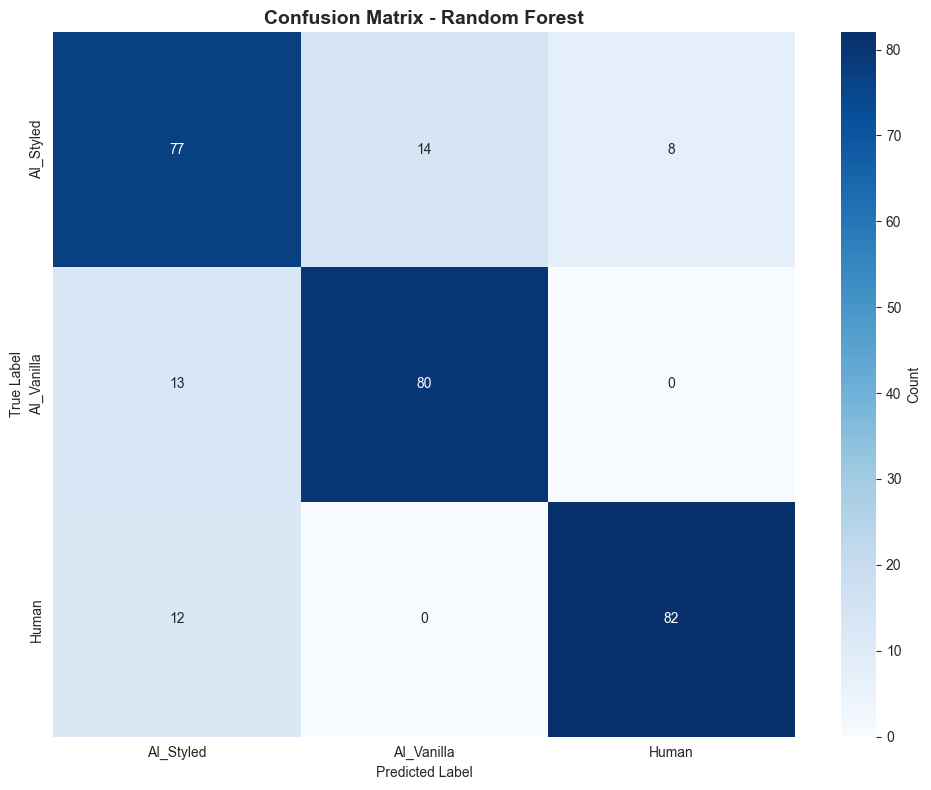


🔍 Confusion Matrix Analysis:
   Diagonal = Correct predictions
   Off-diagonal = Misclassifications

   Look for:
   - Are AI_Vanilla and AI_Styled confused with each other?
   - Is Human well-separated from both AI classes?


In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n🔍 Confusion Matrix Analysis:")
print("   Diagonal = Correct predictions")
print("   Off-diagonal = Misclassifications")
print("\n   Look for:")
print("   - Are AI_Vanilla and AI_Styled confused with each other?")
print("   - Is Human well-separated from both AI classes?")

---

## Step 8: Feature Importance Analysis

Which features matter most?

🔍 FEATURE IMPORTANCE (Random Forest)

   sent_length_variance     : 0.2113
   sent_length_mean         : 0.1995
   fk_grade_mean            : 0.1729
   para_length              : 0.1137
   fk_grade_variance        : 0.0879
   semicolons_per_1k        : 0.0641
   commas_per_1k            : 0.0482
   exclamations_per_1k      : 0.0374
   ttr                      : 0.0362
   emdashes_per_1k          : 0.0288


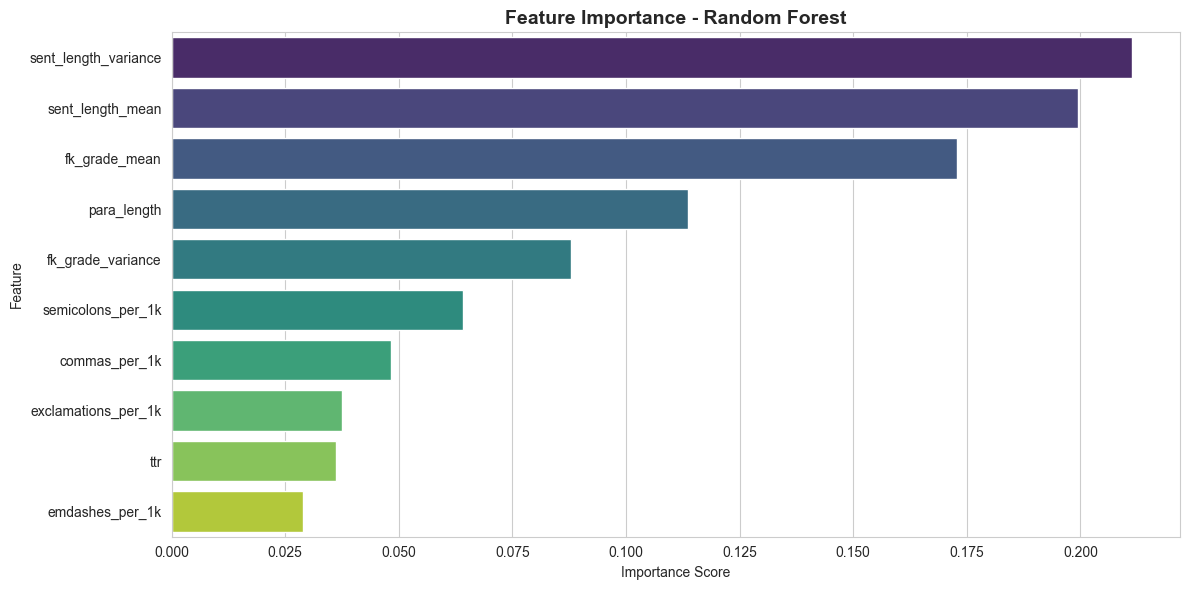


✅ Top 3 most important features:
   1. sent_length_variance: 0.2113
   2. sent_length_mean: 0.1995
   3. fk_grade_mean: 0.1729


In [13]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🔍 FEATURE IMPORTANCE (Random Forest)\n")
print("=" * 60)
for idx, row in feature_importance.iterrows():
    print(f"   {row['feature']:25s}: {row['importance']:.4f}")

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n✅ Top 3 most important features:")
for i in range(min(3, len(feature_importance))):
    row = feature_importance.iloc[i]
    print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

---

## Step 9: Cross-Validation

Verify robustness with 5-fold cross-validation.

In [14]:
print("Running 5-fold cross-validation...")
print("This may take 1-2 minutes...\n")

# Stratified K-Fold (maintains class proportions in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_scores = cross_val_score(
    rf_model, 
    X_train_scaled, 
    y_train, 
    cv=cv, 
    scoring='accuracy',
    n_jobs=-1
)

print("📊 CROSS-VALIDATION RESULTS (5-Fold)\n")
print("=" * 60)
for i, score in enumerate(cv_scores, 1):
    print(f"   Fold {i}: {score:.4f} ({score*100:.2f}%)")
print("=" * 60)
print(f"   Mean:    {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"   Std Dev: {cv_scores.std():.4f}")
print(f"\n✅ Low std dev = consistent performance across folds")

Running 5-fold cross-validation...
This may take 1-2 minutes...

📊 CROSS-VALIDATION RESULTS (5-Fold)

   Fold 1: 0.8253 (82.53%)
   Fold 2: 0.8341 (83.41%)
   Fold 3: 0.8026 (80.26%)
   Fold 4: 0.8246 (82.46%)
   Fold 5: 0.8246 (82.46%)
   Mean:    0.8222 (82.22%)
   Std Dev: 0.0104

✅ Low std dev = consistent performance across folds
📊 CROSS-VALIDATION RESULTS (5-Fold)

   Fold 1: 0.8253 (82.53%)
   Fold 2: 0.8341 (83.41%)
   Fold 3: 0.8026 (80.26%)
   Fold 4: 0.8246 (82.46%)
   Fold 5: 0.8246 (82.46%)
   Mean:    0.8222 (82.22%)
   Std Dev: 0.0104

✅ Low std dev = consistent performance across folds
